# Imports and Function Definition

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt



print('TF Version:', tf.__version__)

import seaborn as sns
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             precision_recall_curve)

2026-01-11 19:02:45.741010: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-11 19:02:46.852845: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-11 19:02:50.112006: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TF Version: 2.20.0


## Data Loading

In [2]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']
AUTOTUNE = tf.data.AUTOTUNE

def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./data/train_hurricane",
        validation_split=0.2,
        subset="training",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./data/train_hurricane",
        validation_split=0.2,
        subset="validation",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./data/test_hurricane",
        class_names=['no_damage', 'damage'],
        shuffle=False,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds, test_ds




## Augementation and Data Preparation

In [3]:
def get_augmentation_layer() -> tf.keras.Sequential:
    """Creates a Keras Sequential model that performs random augmentations."""
    return tf.keras.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomFlip('vertical'),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.2),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),

        # Add Gaussian noise to simulate sensor noise
        layers.GaussianNoise(0.01),
    ], name="data_augmentation")


In [4]:
def prepare_dataset(ds, augment=False):
    """Applies caching, shuffling, augmentation, and prefetching."""
    ds = ds.cache()
    if augment:
        aug_layer = get_augmentation_layer()
        ds = ds.map(lambda x, y: (aug_layer(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    ds = ds.shuffle(1000).prefetch(AUTOTUNE)
    return ds


## BaseLine Model

In [5]:
def build_baseline_model(input_shape=IMG_SHAPE) -> tf.keras.Model:
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)   # binary output
    model = models.Model(inputs, outputs, name="baseline_cnn")
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'precision', 'recall'])
    return model


## Transfer Models

In [6]:
def build_transfer_model(model_name='MobileNetV2',
                         input_shape=IMG_SHAPE,
                         fine_tune_at=None) -> tf.keras.Model:
    """
    Function for returning Transfer Learning models.
    model_name: Any valid tf.keras.applications name (VGG16, MobileNetV2, etc.)
    fine_tune_at: Layer index to start unfreezing. If None, whole base is frozen.
    """

    # Get the keras application for the specific model
    keras_app = getattr(tf.keras.applications, model_name)

    # Get the correct module to extract model specific preprocessing
    parent_module = keras_app.__module__.split('.')[-1]
    preprocess_func = getattr(tf.keras.applications, parent_module).preprocess_input

    # Load the pretrained base 
    base_model = keras_app(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Handling freezing
    if fine_tune_at is None:
        base_model.trainable = False
    else:
        base_model.trainable = True
        # Freeze early layers
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False


    # Contruct final transfer model
    inputs = layers.Input(shape=input_shape)
    x = get_augmentation_layer()(inputs)
    x = preprocess_func(x)
    x = base_model(x, training=False)        
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs, name=f"transfer_{model_name}")

    # Use a lower learning rate for transfer learning 
    lr = 1e-4 if fine_tune_at else 1e-3
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'precision', 'recall']
                  )
    return model


## Callbacks

In [7]:
def get_callbacks(patience_es=5, patience_lr=3):
    return [
        callbacks.EarlyStopping(monitor='val_loss',
                                patience=patience_es,
                                restore_best_weights=True),

        callbacks.ReduceLROnPlateau(monitor='val_loss',
                                    factor=0.5,
                                    patience=patience_lr,
                                    min_lr=1e-6)
    ]


## Model Training

In [8]:
def train_model(model, train_ds, val_ds, epochs=60):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=get_callbacks(),
        verbose=1
    )
    return history


In [9]:
def train_model_partial_unfreeze(model, train_ds, val_ds, epochs=60):
    # Train first epochs frozen
    model.fit(train_ds, validation_data=val_ds, epochs=10)

    #Unfreeze last 20 Layers
    backbone = model.layers[2]               # EfficientNetB0 instance
    for layer in backbone.layers[-20:]:
        layer.trainable = True

    #recompile with lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=get_callbacks()
    )
    return history

In [10]:
def train_vgg16(model, train_ds, val_ds, epochs=60):

    #Unfreeze last 20 Layers
    backbone = model.layers[2]               # EfficientNetB0 instance
    for layer in backbone.layers[:-4]:
        layer.trainable = False

    #recompile with lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=get_callbacks()
    )
    return history

## Training Monitoring


In [11]:
def plot_learning_curves(history, title="Experiment"):
    """
    Diagnostic tool to check for overfitting/underfitting.
    """
    epochs = range(len(history.history['loss']))
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.plot(epochs, history.history[metric], label=f'Train {metric}')
        plt.plot(epochs, history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.title(f'{title}: {metric.capitalize()}')
        plt.legend()
    plt.tight_layout()
    plt.show()

## Evaluation 

In [12]:
def plot_final_evaluation(model, test_ds, fname=None):
    """
    Performs final evaluation on test data.
    Focuses on the Confusion Matrix and class-specific Recall.
    """
    # 1. Collect true labels and predictions
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_probs = model.predict(test_ds)
    y_pred = (y_probs > 0.5).astype(int)

    # 2. Print the Scientific Summary
    print("--- EVALUATION SUMMARY ---")
    print(classification_report(y_true, y_pred, target_names=['No Damage', 'Damage']))

    # 3. Plot Normalized Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', 
                xticklabels=['No Damage', 'Damage'], 
                yticklabels=['No Damage', 'Damage'])
    plt.title(f'Confusion Matrix: {model.name}')
    plt.ylabel('Actual Status')
    plt.xlabel('Predicted Status')

    if fname:
        plt.savefig(fname)
    plt.show()



def plot_precision_recall(model, test_ds, fname=None):
    """
    Visualizes the trade-off between Precision and Recall.
    Crucial for proving the model's reliability in disaster scenarios.
    """
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_probs = model.predict(test_ds)
    
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    
    plt.figure(figsize=(7, 5))
    plt.plot(recall, precision, color='darkorange', lw=2)
    plt.fill_between(recall, precision, alpha=0.2, color='orange')
    plt.xlabel('Recall (Ability to find all damage)')
    plt.ylabel('Precision (Ability to be correct when finding damage)')
    plt.title(f'Precision-Recall Curve: {model.name}')
    plt.grid(True)

    if fname:
        plt.savefig(fname)
    plt.show()

In [13]:
def get_metrics_summary(histories):
    summary = []
    for name, history in histories.items():
        # Get the metrics from the final epoch
        metrics = {
            "Model": name,
            "Val Accuracy":  history.history['val_accuracy'][-1],
            "Val Precision": history.history['val_precision'][-1],
            "Val Recall":    history.history['val_recall'][-1]
        }
        # Calculate F1 manually as it's often not in the history dict
        p = metrics["Val Precision"]
        r = metrics["Val Recall"]
        metrics["Val F1"] = 2 * (p * r) / (p + r + 1e-7)
        
        summary.append(metrics)
    
    return pd.DataFrame(summary)

# Load Data

In [14]:
train_ds, val_ds, test_ds = prepare_train_and_val_datasets()

Found 1358 files belonging to 2 classes.


Using 1087 files for training.


I0000 00:00:1768158187.221143    4142 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


Found 1358 files belonging to 2 classes.
Using 271 files for validation.
Found 12228 files belonging to 2 classes.


# Baseline

In [15]:
train_ds_aug = prepare_dataset(train_ds, augment=True)
val_ds_prep = prepare_dataset(val_ds, augment=False)

In [ ]:
baseline = build_baseline_model()
baseline_hist = train_model(baseline, train_ds_aug, val_ds_prep)

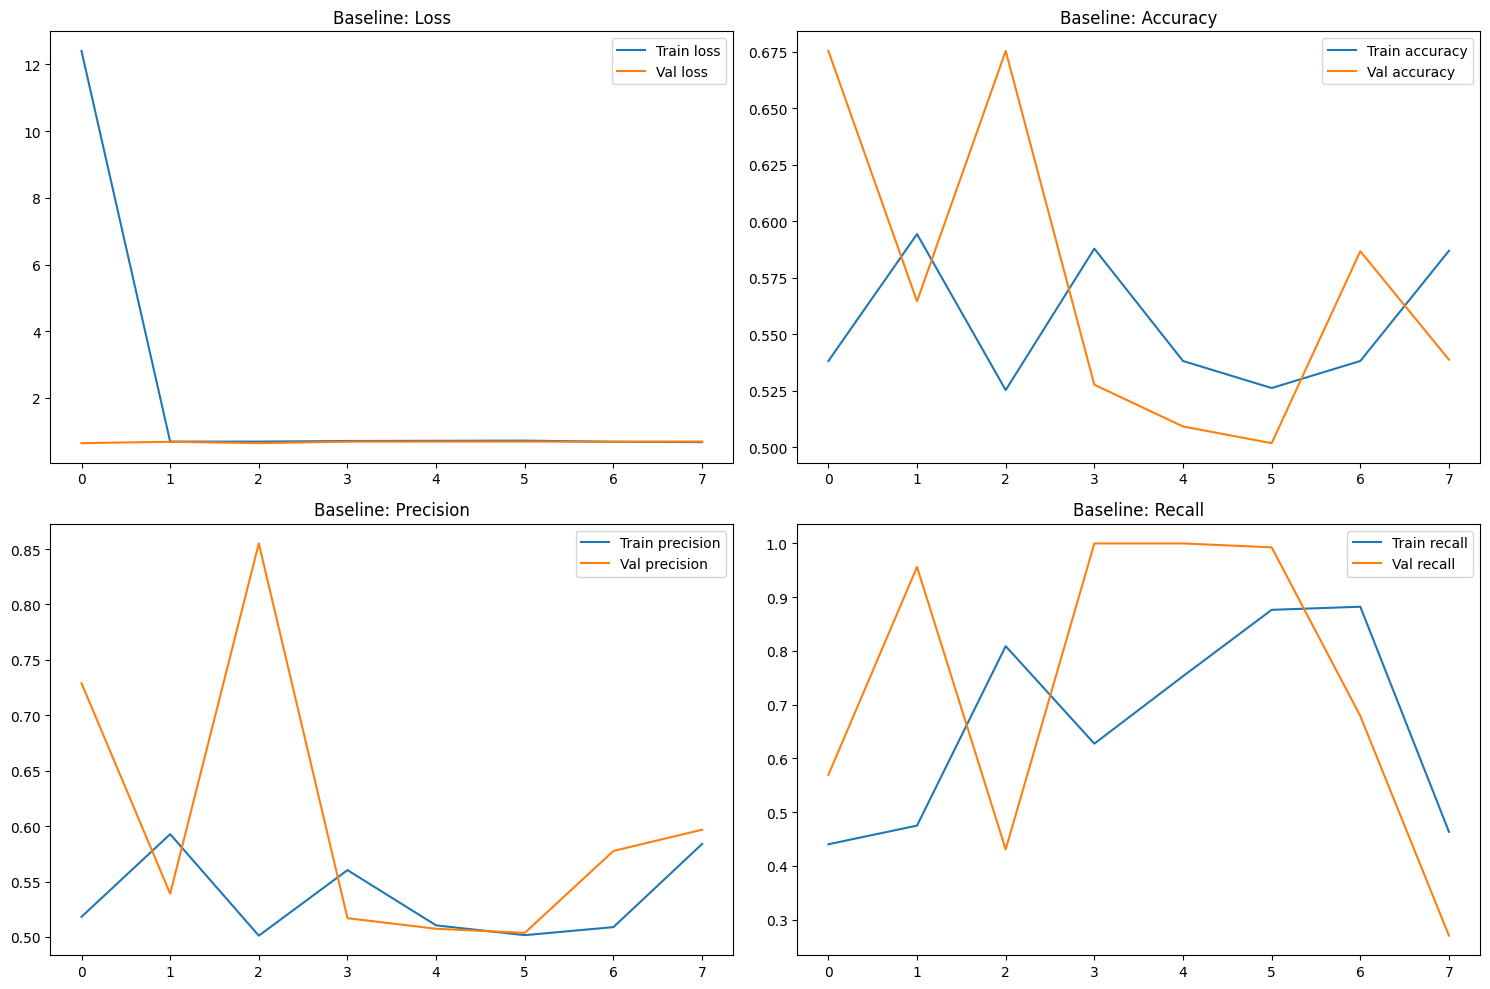

In [17]:
plot_learning_curves(baseline_hist, title="Baseline")

2026-01-10 22:38:05.798177: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step
--- SCIENTIFIC EVALUATION SUMMARY ---
              precision    recall  f1-score   support

   No Damage       0.52      0.77      0.62      6333
      Damage       0.49      0.23      0.31      5895

    accuracy                           0.51     12228
   macro avg       0.50      0.50      0.47     12228
weighted avg       0.50      0.51      0.47     12228



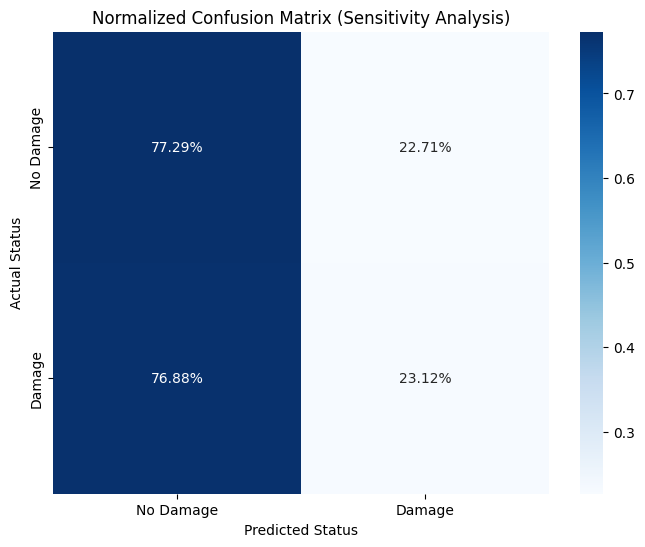

In [18]:
plot_final_evaluation(baseline, test_ds)

 1/96 ━━━━━━━━━━━━━━━━━━━━ 16s 174ms/step

2026-01-10 22:41:17.863245: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step


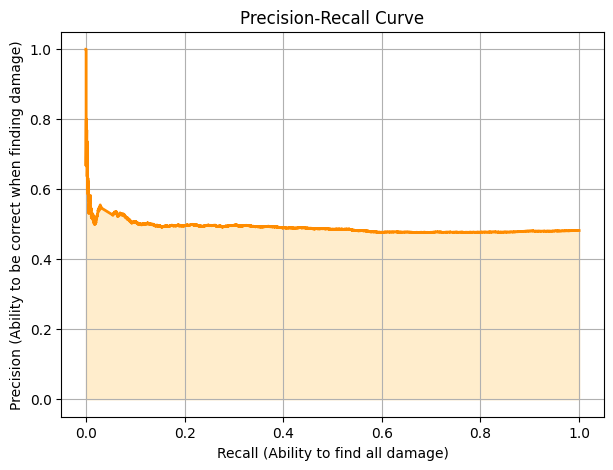

In [24]:
plot_precision_recall(baseline, test_ds)

# Transfer Learning

VGG16 - Classic
MobileNetV2 - LightWeight
EfficientNetB0 - Modern
ResNet50 - Heavy

In [42]:
import pickle

def save_pickle(data, filename="histories.pkl"):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

def load_pickle(filename="histories.pkl"):
    with open(rb) as f:
        return pickle.load(f)

In [ ]:
models_to_test = ['VGG16', 'MobileNetV2', 'EfficientNetB0', 'ResNet50']
histories = {} 

for name in models_to_test:
    try:
        print(f"\n--- Initializing Experiment: {name} ---")
        
        # Build
        model = build_transfer_model(model_name=name)
        
        # Train
        print(f"Training {name}...")
        history = train_model(model, train_ds, val_ds)

        # Save the actual model file
        model.save(f"model_{name}.keras",include_optimizer=False)

        # Save history
        save_pickle(history, filename=f"{name}.pkl")
        
        # Save result
        histories[name] = history
        print(f"Successfully completed {name}.")
        
    except AttributeError:
        print(f"[ERROR]: Model '{name}' not found in tf.keras.applications. Skipping...")
    except Exception as e:
        print(f"[ERROR]: An unexpected error occurred with {name}: {e}. Skipping...")
        continue 

print("\n--- All experiments finished. ---")

In [45]:
df_results = get_metrics_summary(histories)

In [47]:
df_results


,Model,Val Accuracy,Val Precision,Val Recall,Val F1
0,VGG16,0.889299,0.863946,0.927007,0.894366
1,MobileNetV2,0.837638,0.897436,0.766423,0.826772
2,EfficientNetB0,0.896679,0.897810,0.897810,0.897810
3,ResNet50,0.922509,0.920290,0.927007,0.923636


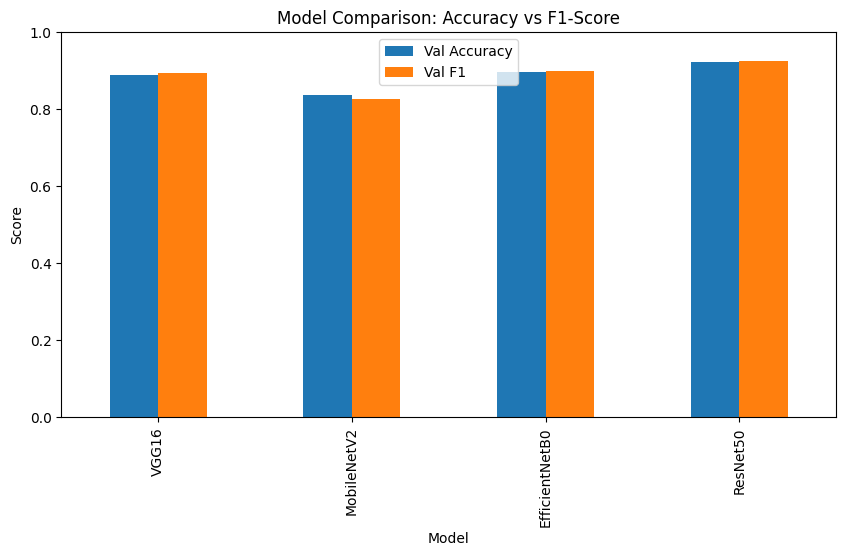

In [46]:
df_results.set_index("Model")[["Val Accuracy", "Val F1"]].plot(kind="bar", figsize=(10, 5))
plt.title("Model Comparison: Accuracy vs F1-Score")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

# Evaluate ResNet50

In [15]:
ResNet50_model = load_model('model_ResNet50.keras')


2026-01-11 17:23:00.657430: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step
--- EVALUATION SUMMARY ---
              precision    recall  f1-score   support

   No Damage       0.92      0.95      0.93      6333
      Damage       0.95      0.91      0.93      5895

    accuracy                           0.93     12228
   macro avg       0.93      0.93      0.93     12228
weighted avg       0.93      0.93      0.93     12228



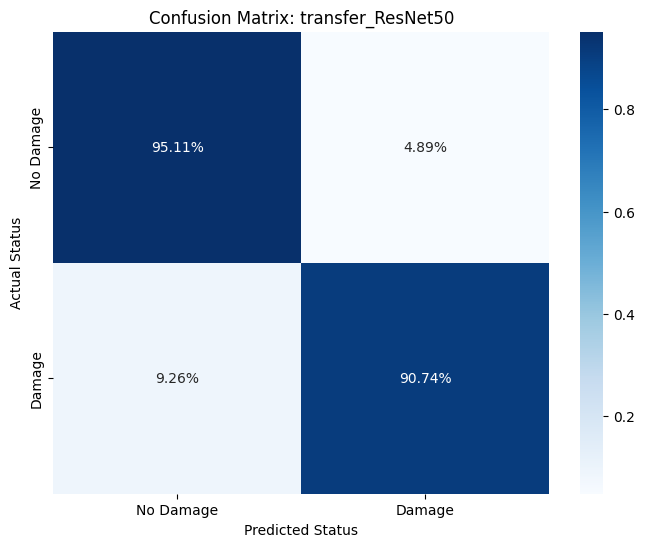

In [21]:
plot_final_evaluation(ResNet50_model, test_ds, fname="cm_resnet50.png")

2026-01-11 19:04:19.444925: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-01-11 19:04:21.888319: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002


96/96 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step


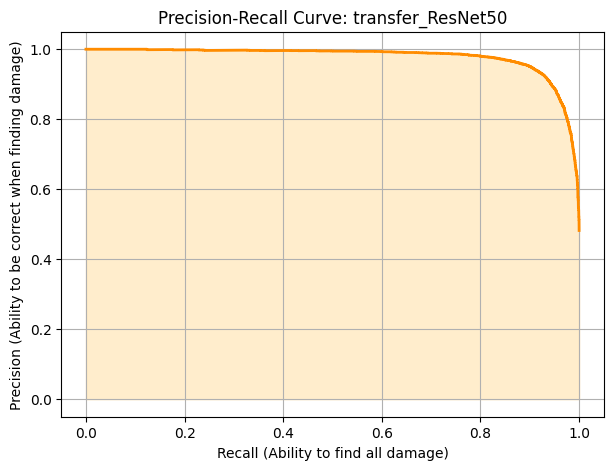

In [16]:
plot_precision_recall(ResNet50_model, test_ds, fname="resnet50_precrec")

In [28]:
def get_confident_errors(model, dataset, class_names):
    all_images = []
    all_labels = []
    all_probs = []

    # Collect data from the test set
    for images, labels in dataset:
        probs = model.predict(images, batch_size=16, verbose=0)
        all_images.append(images.numpy())
        all_labels.append(labels.numpy())
        all_probs.append(probs)

    all_images = np.concatenate(all_images)
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs).flatten()

    # Calculate absolute error (e.g., |0.99 - 0| = 0.99)
    errors = np.abs(all_probs - all_labels)
    
    # Get indices of the top 9 largest errors
    top_error_idx = np.argsort(errors)[-9:]
    
    return all_images[top_error_idx], all_labels[top_error_idx], all_probs[top_error_idx]

In [29]:
def plot_errors(images, labels, probs, class_names):
    plt.figure(figsize=(15, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        # Robust Rescaling: This brings any range back to [0, 1] for display
        img = images[i]
        img = (img - img.min()) / (img.max() - img.min() + 1e-7)
        plt.imshow(img)
        
        actual = class_names[int(labels[i])]
        pred_prob = probs[i]
        pred_label = class_names[1] if pred_prob > 0.5 else class_names[0]
        
        plt.title(f"Actual: {actual}\nPred: {pred_label} ({pred_prob:.4f})")
        plt.axis('off')
    plt.tight_layout()
    plt.show()



2026-01-11 00:44:06.345831: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2026-01-11 00:44:06.345881: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 619.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2026-01-11 00:44:33.087650: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


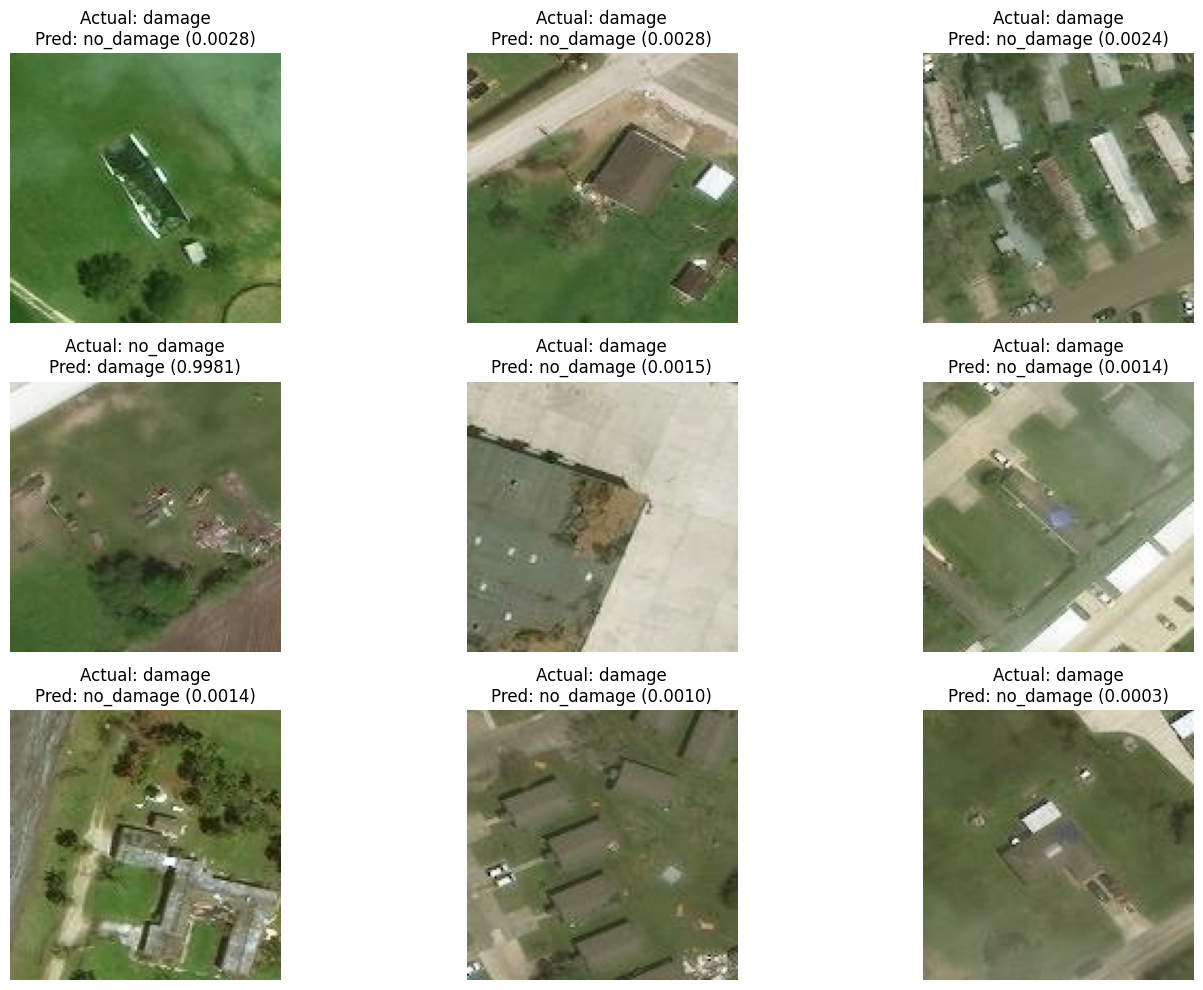

In [30]:
# Execution
images, labels, probs = get_confident_errors(ResNet50_model, test_ds, ['no_damage', 'damage'])
plot_errors(images, labels, probs, ['no_damage', 'damage'])

## Checking locational data leakage

In [21]:
import re, os
import pandas as pd
from scipy.spatial.distance import cdist

def extract_coords(filename):
    # This regex looks for patterns like 29.1234_-95.1234 or similar
    coords = re.findall(r"[-+]?\d*\.\d+|\d+", filename)
    return [float(coords[0]), float(coords[1])] if len(coords) >= 2 else [0, 0]

#Get all filenames
train_files = os.listdir("./data/train_hurricane/damage")
test_files = os.listdir("./data/test_hurricane/damage")

#Extract Lat/Long into DataFrames
df_train = pd.DataFrame([extract_coords(f) for f in train_files], columns=['lat', 'lon'])
df_test = pd.DataFrame([extract_coords(f) for f in test_files], columns=['lat', 'lon'])

#Calculate distance between every Test point and its nearest Train neighbor

distances = cdist(df_test, df_train, metric='euclidean')
min_distances = distances.min(axis=1)

print(f"Average 'Distance' to nearest training neighbor: {min_distances.mean():.6f}")
print(f"Percentage of test images 'dangerously close' (< 0.001): {(min_distances < 0.001).mean():.2%}")

Average 'Distance' to nearest training neighbor: 0.004512
Percentage of test images 'dangerously close' (< 0.001 change): 41.32%


In [26]:
import glob
import pandas as pd
from scipy.spatial.distance import cdist

# Get ALL test files (damage + no_damage) sorted alphabetically
all_test_files = sorted(glob.glob("./data/test_hurricane/**/*.*", recursive=True))

# Extract coordinates for all 12,228 files
df_test_all = pd.DataFrame([extract_coords(f) for f in all_test_files], columns=['lat', 'lon'])

# Re-calculate distances against your full Training set
distances = cdist(df_test_all, df_train, metric='euclidean')
min_distances = distances.min(axis=1) 

print(f"Mask size: {len(min_distances)}")

Mask size: 12228


In [27]:
# Get all labels and predictions in order
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = ResNet50_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

2026-01-11 02:00:42.918114: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [25]:
len(min_distances)

5895

In [28]:
# Ensure min_distances matches the length of y_true
# If you used a generator, make sure the file order is the same!
far_mask = min_distances >= 0.001

# Calculate the difference
leaked_acc = (y_true[~far_mask] == y_pred[~far_mask]).mean()
scientific_acc = (y_true[far_mask] == y_pred[far_mask]).mean()

print(f"Accuracy on Neighbors (Leaked): {leaked_acc:.2%}")
print(f"Accuracy on New Areas (Scientific): {scientific_acc:.2%}")

Accuracy on Neighbors (Leaked): 96.11%
Accuracy on New Areas (Scientific): 90.46%


# Evaluate MobileNetV2


In [19]:
MobileNetV2_model = load_model('model_MobileNetV2.keras')

2026-01-11 00:35:00.312173: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-01-11 00:35:02.097886: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2026-01-11 00:35:02.479340: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 240.02MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2026-01-11 00:35:02.488673: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 412.01MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


96/96 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step
--- EVALUATION SUMMARY ---
              precision    recall  f1-score   support

   No Damage       0.85      0.90      0.87      6333
      Damage       0.89      0.83      0.86      5895

    accuracy                           0.87     12228
   macro avg       0.87      0.87      0.87     12228
weighted avg       0.87      0.87      0.87     12228



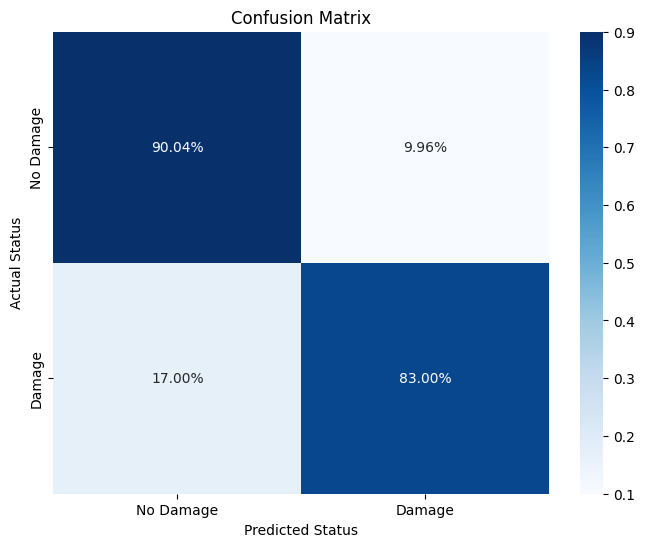

In [20]:
plot_final_evaluation(MobileNetV2_model, test_ds)

 3/96 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step

2026-01-11 00:35:33.370605: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step


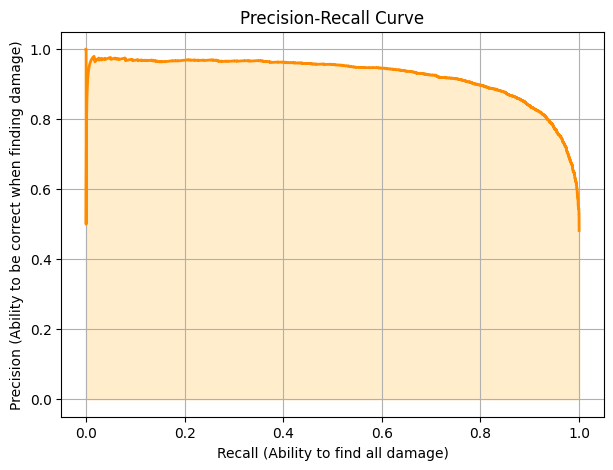

In [21]:
plot_precision_recall(MobileNetV2_model, test_ds)